In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [9]:
device = 'cuda:0'
conf = ffhq256_autoenc()
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [10]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [12]:
img_dir = 'imgs_align'
for i,file in enumerate(os.listdir(img_dir)):
    print(f'{i}: {file}')

0: idPhoto.png
1: megane.png
2: sample01.png
3: sandy.png
4: women_default.png
5: yotaka_default.png
6: yotaka_smile.png


In [46]:
data = ImageDataset(img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[1]['img'][None]

In [47]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


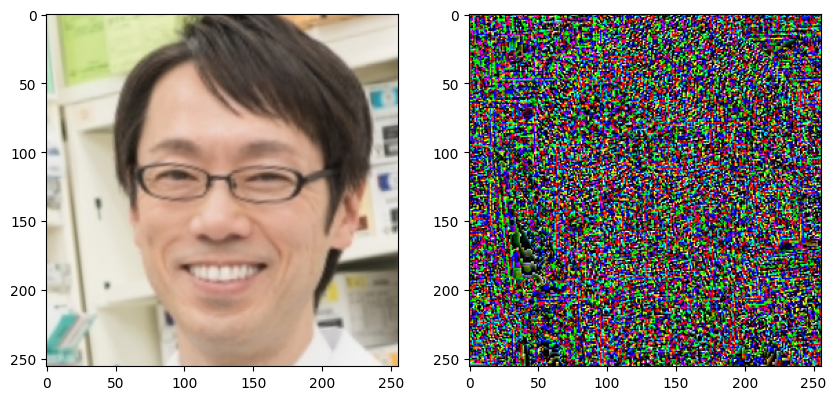

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [49]:
print(CelebAttrDataset.id_to_cls)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [50]:
cls_id = CelebAttrDataset.cls_to_id['Smiling']

In [51]:
cond2 = cls_model.normalize(cond)
cond3 = cond2 + 0.3 * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
cond4 = cls_model.denormalize(cond3)

In [73]:
cond_a = cls_model.normalize(cond)
cond_b = cond_a*math.sqrt(512)
cond_c = cls_model.denormalize(cond_a)

In [108]:
print(torch.norm(F.normalize(cls_model.classifier.weight[cls_id][None, :])))
print(torch.norm(F.normalize(cls_model.classifier.weight[cls_id][None, :]))*math.sqrt(512)*0.3)
print(torch.norm(cls_model.classifier.weight[cls_id]))
print(torch.norm(cond2))

tensor(1.0000, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(6.7882, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4241, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(25.5469, device='cuda:0')


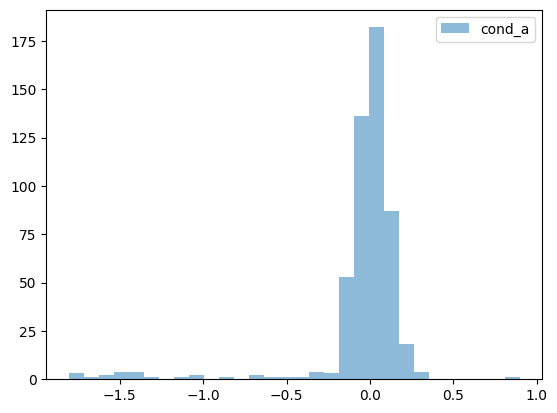

In [88]:
import matplotlib.pyplot as plt
plt.hist(cond.detach().clone().to('cpu'), alpha=0.5, label='cond_a', bins=30)
# plt.hist(cond2.detach().clone().to('cpu'), alpha=0.5, label='cond_b', bins=30)
# plt.hist(cond3.detach().clone().to('cpu'), alpha=0.5, label='cond_c', bins=30)
plt.legend()
plt.show()

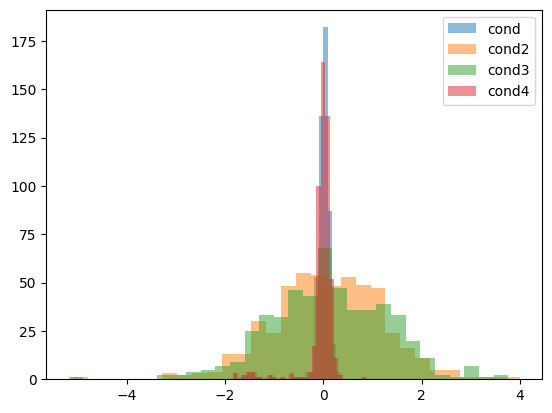

In [52]:
import matplotlib.pyplot as plt
plt.hist(cond.detach().clone().to('cpu'), alpha=0.5, label='cond', bins=30)
plt.hist(cond2.detach().clone().to('cpu'), alpha=0.5, label='cond2', bins=30)
plt.hist(cond3.detach().clone().to('cpu'), alpha=0.5, label='cond3', bins=30)
plt.hist(cond4.detach().clone().to('cpu'), alpha=0.5, label='cond4', bins=30)
plt.legend()
plt.show()

In [53]:
mean = cond.mean()
dev = cond-mean
std = cond.std()
cond5 = dev/std
cond6 = cond/std
cond7 = F.normalize(cond)
cond8 = F.normalize(cond)*math.sqrt(512)

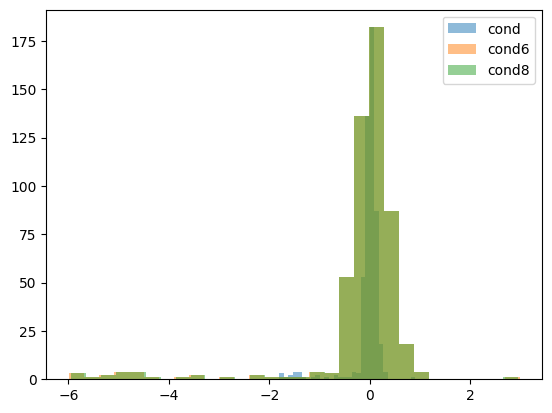

In [67]:
# plt.hist(cond.detach().clone().to('cpu'), alpha=0.5, label='cond', bins=30)
# plt.hist(cond2.detach().clone().to('cpu'), alpha=0.5, label='cond2', bins=30)
# plt.hist(cond5.detach().clone().to('cpu'), alpha=0.5, label='cond5', bins=30)
plt.hist(cond6.detach().clone().to('cpu'), alpha=0.5, label='cond6', bins=30)
# plt.hist(cond7.detach().clone().to('cpu'), alpha=0.5, label='cond7', bins=30)
plt.hist(cond8.detach().clone().to('cpu'), alpha=0.5, label='cond8', bins=30)
plt.legend()
plt.show()

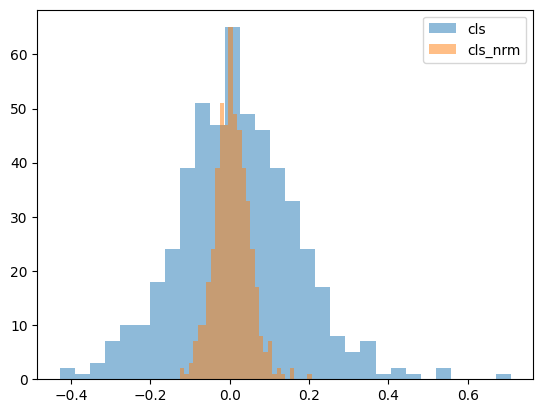

In [85]:
plt.hist(cls_model.classifier.weight[cls_id].detach().clone().to('cpu'), alpha=0.5, label='cls', bins=30)
plt.hist(F.normalize(cls_model.classifier.weight[cls_id][None]).detach().clone().to('cpu'), alpha=0.5, label='cls_nrm', bins=30)
plt.legend()
plt.show()

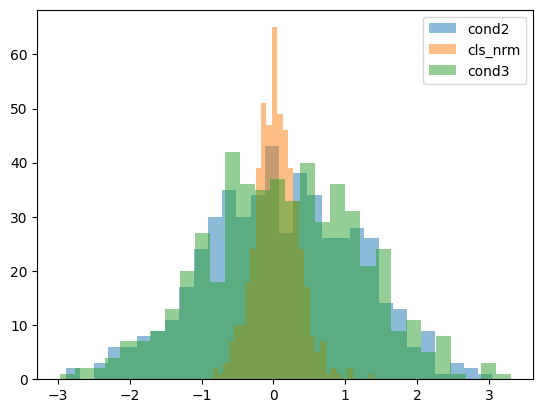

In [35]:
plt.hist(cond2.detach().clone().to('cpu'), alpha=0.5, label='cond2', bins=30)
plt.hist(0.3*math.sqrt(512)*F.normalize(cls_model.classifier.weight[cls_id][None]).detach().clone().to('cpu'), alpha=0.5, label='cls_nrm', bins=30)
plt.hist(cond3.detach().clone().to('cpu'), alpha=0.5, label='cond3', bins=30)
plt.legend()
plt.show()

In [72]:
state['state_dict'].keys()

dict_keys(['conds_mean', 'conds_std', 'classifier.weight', 'classifier.bias', 'ema_classifier.weight', 'ema_classifier.bias'])

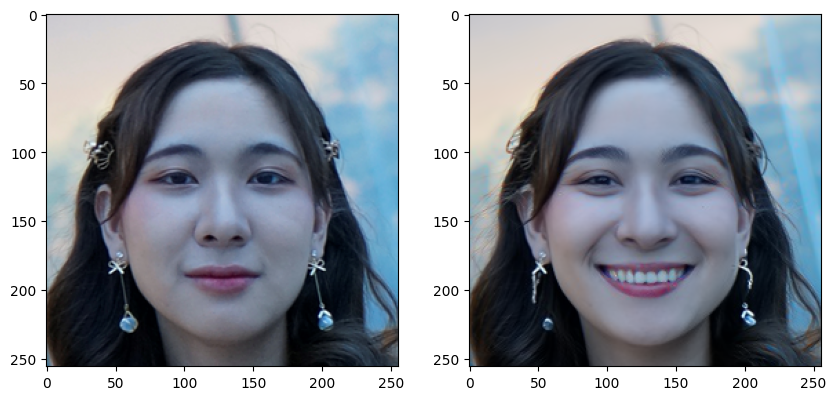

In [12]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
# plt.savefig('imgs_manipulated/compare1.png')

In [13]:
from torchvision.utils import *
save_image(img[0], 'imgs_manipulated/output.png')